In [7]:
# !pip install forex_python
# !sudo apt-get install binutils libproj-dev gdal-bin

!pip install pickle5
!pip install geopy

In [1]:
import pickle5 as pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [2]:
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

In [3]:
ADD_GEO_MAP = pickle.load(open('models/add_to_geo_map.pkl', 'rb'))

In [4]:
def geo_loc(point = None, address = None):
    
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="map.app")
    
    if address is None:
        try:
            location = geolocator.reverse(point)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid geo-coordinates !!'
    else:
        try:
            location = geolocator.geocode(address)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid Address !!'

In [5]:
FOREX = pickle.load(open("models/exchange_rates.pkl", "rb"))

In [6]:
%%time
df['usd_amt'] = df[['33b_orig_ord_amt', '33b_cur']].apply(lambda x: 
                                                            x[0] * FOREX[x[1]], 
                                                            axis = 1)

CPU times: user 2.64 s, sys: 64.5 ms, total: 2.7 s
Wall time: 2.7 s


In [7]:
from collections import OrderedDict
def get_top_remitters(n = 100):
    return OrderedDict(sorted(
        (df.groupby(['50f_payor_add_ln_2'])['usd_amt'].sum() / df.groupby(['50f_payor_add_ln_2'])['usd_amt'].count())
            .to_dict().items(), key=lambda x: x[1], reverse=True)[:n])

In [8]:
def get_top_beneficiaries(n = 100):
    return OrderedDict(sorted(
        (df.groupby(['59f_ben_add_ln_2'])['usd_amt'].sum() / df.groupby(['59f_ben_add_ln_2'])['usd_amt'].count())
        .to_dict().items(), key=lambda x: x[1], reverse=True)[:n])

60696.30031743348
727.4092151548141
  US FRANKLIN      23
  US NEWPORT       21
  US GREENVILLE    19
  US PERRY         18
  US CLINTON       18
Name: 50f_payor_add_ln_2, dtype: int64


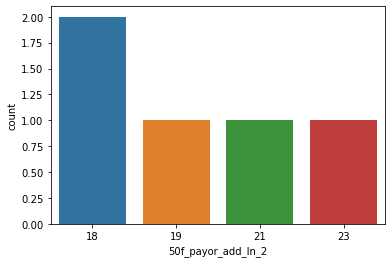

67327.070024193
1833.083404961254
  US FRANKLIN     23
  US JEFFERSON    22
  US CLINTON      20
  US MADISON      20
  US NEWPORT      17
Name: 50f_payor_add_ln_2, dtype: int64


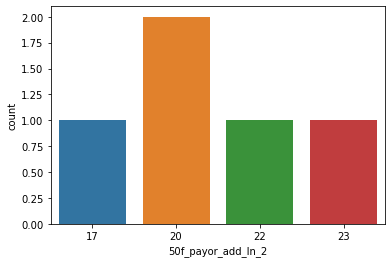

75375.71511224456
2852.7798089106536
  US MADISON        24
  US CLINTON        20
  US FRANKLIN       19
  US SPRINGFIELD    19
  US JACKSON        18
Name: 50f_payor_add_ln_2, dtype: int64


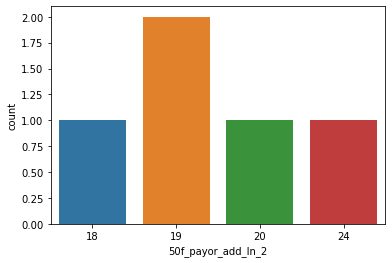

85444.63333120168
3855.688788391891
  US MADISON        24
  US WASHINGTON     24
  US AUBURN         20
  US SPRINGFIELD    19
  US CLINTON        19
Name: 50f_payor_add_ln_2, dtype: int64


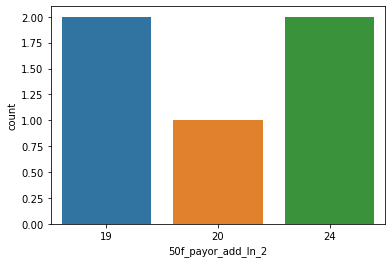

98541.51321020603
4850.702028841552
  US CLINTON      20
  US JACKSON      20
  US HUDSON       19
  US LEXINGTON    19
  US CHESTER      17
Name: 50f_payor_add_ln_2, dtype: int64


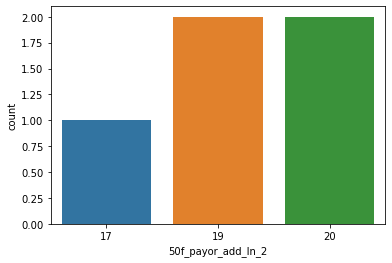

116483.36547281341
5864.251069112508
  US JACKSON       21
  US MADISON       20
  US FRANKLIN      20
  US WASHINGTON    20
  US MANCHESTER    19
Name: 50f_payor_add_ln_2, dtype: int64


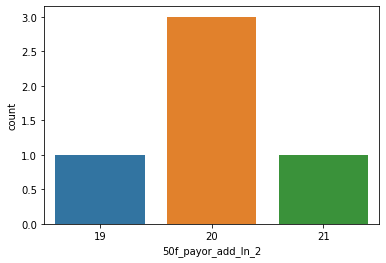

142871.5687692679
7041.59534048062
  US SALEM         22
  US NEWPORT       22
  US MADISON       21
  US GREENVILLE    21
  US FARMINGTON    20
Name: 50f_payor_add_ln_2, dtype: int64


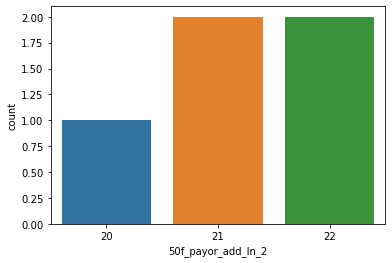

185792.74271813774
8650.887000763712
  US HENDERSON     18
  US FRANKLIN      18
  US TRENTON       18
  US WINCHESTER    17
  US ALBION        16
Name: 50f_payor_add_ln_2, dtype: int64


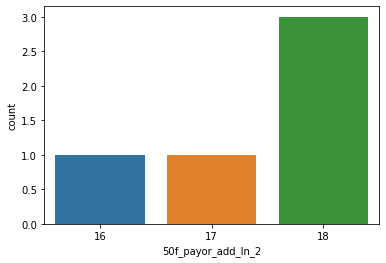

268732.3060306638
11482.157201508468
  US FARMINGTON    23
  US SALEM         21
  US FRANKLIN      21
  US OXFORD        19
  US CLINTON       17
Name: 50f_payor_add_ln_2, dtype: int64


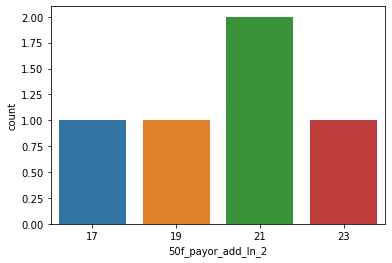

503325.7389277696
60667.03375082648
  US CLINTON         25
  US MADISON         20
  US MOUNT VERNON    20
  US TROY            19
  US SPRINGFIELD     18
Name: 50f_payor_add_ln_2, dtype: int64


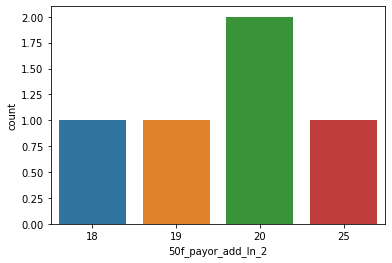

In [9]:
# %%time
df[(df['usd_amt'] > np.quantile(df['usd_amt'], 0.90)) & 
   (df['usd_amt'] <= np.quantile(df['usd_amt'], 0.25))]['50f_payor_add_ln_2'].value_counts()
for quant in range(10):
    # df[df['usd_amt'] > np.quantile(df['usd_amt'], 0.90)]['50f_payor_add_ln_2'].value_counts()
    print(df[df['usd_amt'] > np.quantile(df['usd_amt'], 0.1 * quant)]['usd_amt'].mean())
    print(df[df['usd_amt'] <= np.quantile(df['usd_amt'], 0.1 * (quant + 1))]['usd_amt'].mean() )
    hist = df[(df['usd_amt'] > np.quantile(df['usd_amt'], 0.1 * quant)) & 
           (df['usd_amt'] <= np.quantile(df['usd_amt'], 0.1 * (quant + 1)))]['50f_payor_add_ln_2'].value_counts()[:5]
    print(hist)
    sns.countplot(hist)
    plt.show()

In [10]:
def get_lat_long(address):
    try:
        point_ = ADD_GEO_MAP[address.strip()]
        return point_['latitude'], point_['longitude']
    except:
        point_ = geo_loc(address = address.strip())
        return point_[2]['lat'], point_[2]['lon']
    else:
        return 0, 0

In [11]:
%%time
# Extract the data we're interested in
toppers = get_top_remitters(2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]

CPU times: user 93.7 ms, sys: 0 ns, total: 93.7 ms
Wall time: 92.9 ms


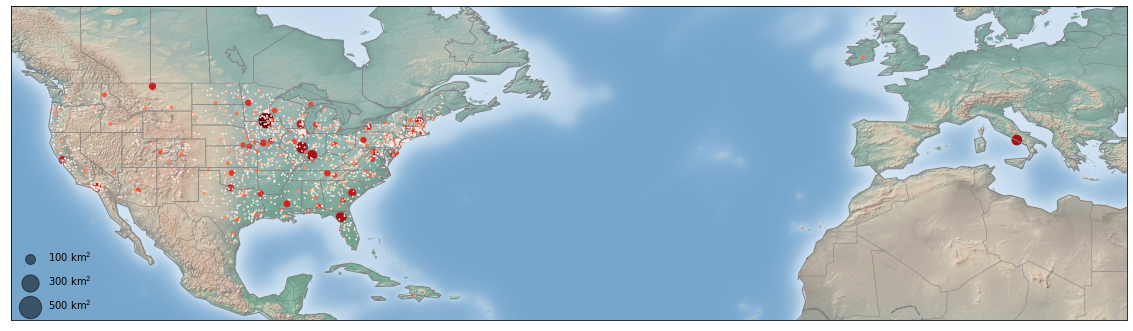

In [12]:
# 1. Draw the map background
fig = plt.figure(figsize=(20, 10))
# m = Basemap(projection='lcc', resolution='c', 
#             lat_0=31, lon_0=-130,
#             width=6E6, height=3.2E6)

m = Basemap(projection='cyl', resolution='c',
            llcrnrlat = 15, urcrnrlat = 60,
            llcrnrlon = -130, urcrnrlon = 30)

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, 
          c=np.log10(amount), s = (np.array(amount)/100000).tolist(),
          cmap='Reds', alpha=1)

# 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm amount})$')
# plt.clim(min_, max_)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

In [13]:
%%time
# Extract the data we're interested in
toppers = get_top_beneficiaries(2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]
min_, max_ = np.log10(np.array(amount)).min(), np.log10(np.array(amount)).max()

CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 106 ms


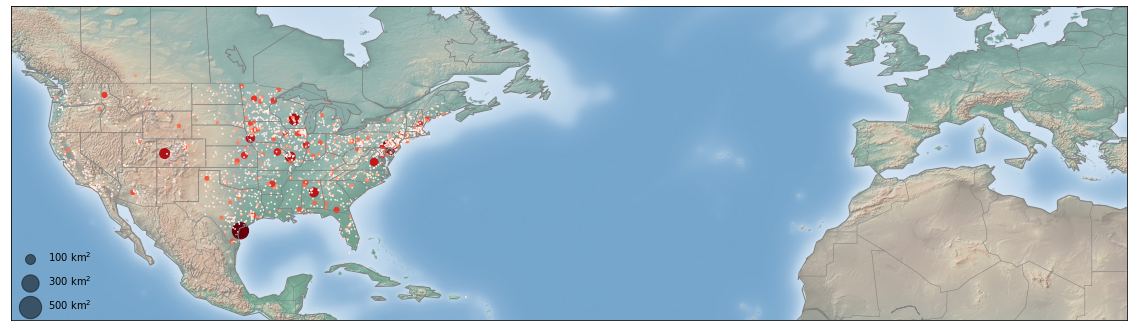

In [14]:
# 1. Draw the map background
fig = plt.figure(figsize=(20, 10))
# m = Basemap(projection='lcc', resolution='c', 
#             lat_0=31, lon_0=-130,
#             width=6E6, height=3.2E6)

m = Basemap(projection='cyl', resolution='c',
            llcrnrlat = 15, urcrnrlat = 60,
            llcrnrlon = -130, urcrnrlon = 30)

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, 
          c=np.log10(amount), s = (np.array(amount)/100000).tolist(),
          cmap='Reds', alpha=1)

# 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm amount})$')
# plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

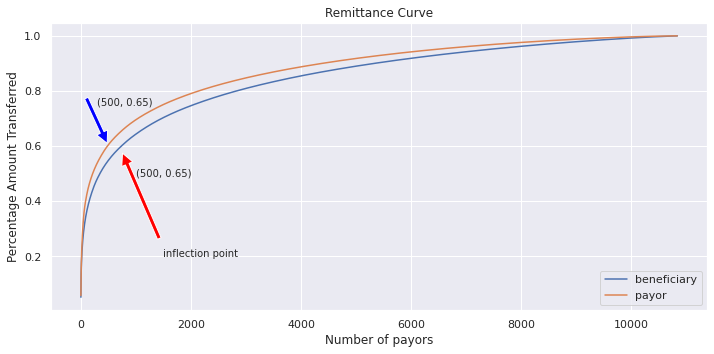

CPU times: user 869 ms, sys: 108 ms, total: 977 ms
Wall time: 760 ms


In [100]:
%%time
sns.set()

%matplotlib inline

toppers = get_top_beneficiaries(2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]

fig, ax = plt.subplots(figsize=(10, 5))

# plt.subplot(121)
amount_list = sorted(df.groupby(['59f_ben_add_ln_2'])['usd_amt'].sum().to_dict().items(), key = lambda x: x[1], reverse = True)
sum_ = 0.
arr_ = []
SUM = np.array(np.array(amount_list)[:, 1], dtype='float').sum()
for x in np.array(np.array(amount_list)[:, 1], dtype='float'):
    sum_ += x
    arr_.append(sum_/SUM)
np.array(np.array(amount_list)[:, 1], dtype='float')
plt.plot(arr_)

ax.annotate('inflection point', xy=(700, .6), xytext=(1500, 0.2),
            # arrowprops=dict(arrowstyle="wedge, tail_width=1", alpha=1))
            # arrowprops=dict(facecolor='red', shrink=0.15))
            arrowprops=dict(facecolor='red', shrink=0.07))


ax.annotate('(500, 0.65)', xy=(700, .6), xytext=(1000, 0.49))

plt.title('Remittance Curve')
plt.xlabel('Number of Beneficiaries')
plt.ylabel('Percentage Amount Transferred')

# plt.subplot(122)

toppers = get_top_remitters(2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]

amount_list = sorted(df.groupby(['50f_payor_add_ln_2'])['usd_amt'].sum().to_dict().items(), key = lambda x: x[1], reverse = True)
sum_ = 0.
arr_ = []
SUM = np.array(np.array(amount_list)[:, 1], dtype='float').sum()
for x in np.array(np.array(amount_list)[:, 1], dtype='float'):
    sum_ += x
    arr_.append(sum_/SUM)
np.array(np.array(amount_list)[:, 1], dtype='float')
plt.plot(arr_)

ax.annotate(' ', xy=(500, .6), xytext=(0, 0.8),
            # arrowprops=dict(arrowstyle="wedge, tail_width=1", alpha=1))
            # arrowprops=dict(facecolor='red', shrink=0.15))
            arrowprops=dict(facecolor='blue', shrink=0.05))

ax.annotate('(500, 0.65)', xy=(400, .65), xytext=(300, 0.75))


plt.title('Remittance Curve')
plt.xlabel('Number of payors')
plt.ylabel('Percentage Amount Transferred')
plt.tight_layout(True)
plt.legend(["beneficiary", "payor"], loc ="lower right")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'data' is not defined

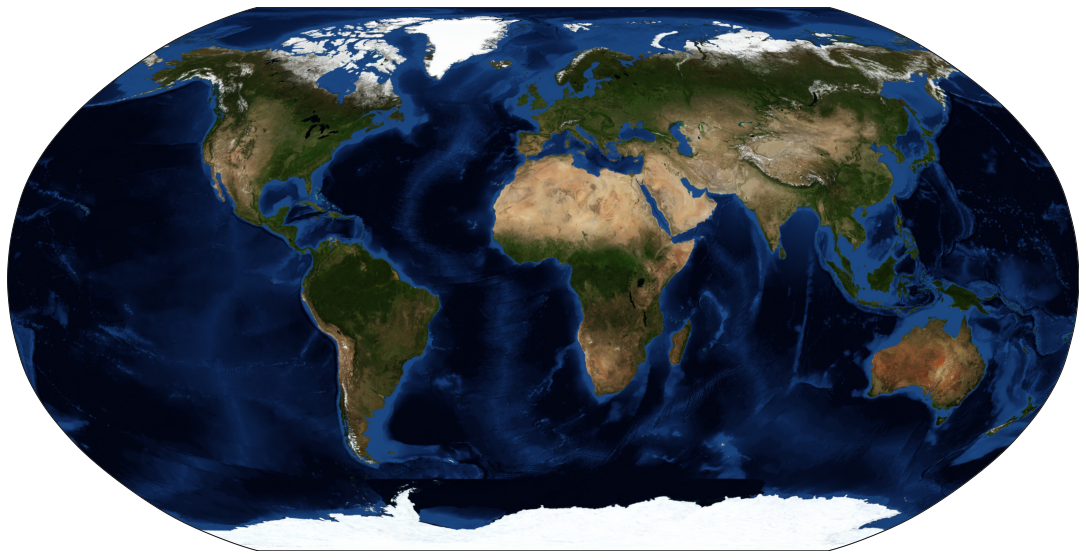

In [16]:
# 1. Draw the map background
fig = plt.figure(figsize=(25, 10))
# m = Basemap(projection='lcc', resolution='c', 
#             lat_0=31, lon_0=-130,
#             width=6E6, height=3.2E6)

m = Basemap(projection='robin', lon_0 = 0, lat_0 = 50, lat_1 = 20, lat_2 = 90,
           width = 1.6E7, height = 1.2E7, resolution = 'c')
m.bluemarble(scale=0.5)
                   
for name, row in data[data['src_lon'] != 0][:1000].iterrows():
    m.drawgreatcircle(row['src_lon'], row['src_lat'], 
                      row['target_lon'], row['target_lat'])

In [ ]:
df['50f_payor_add_ln_2'] = df['50f_payor_add_ln_2'].str.strip()
df['50k_payor_add_ln_2'] = df['50k_payor_add_ln_2'].str.strip()
df['59f_ben_add_ln_2'] = df['59f_ben_add_ln_2'].str.strip()

In [ ]:
data = pd.DataFrame()
data = df[['33b_cur', '33b_orig_ord_amt']]
conditions = [
    df['50f_payor_add_lon'] != "",
    df["50k_payor_add_lon"] != ""]
choices = [df["50f_payor_add_lon"], df["50k_payor_add_lon"]]
data['src_lon'] = np.select(conditions, choices, default=0)
conditions = [
    df["50f_payor_add_lat"] != "",
    df["50k_payor_add_lat"] != ""]
choices = [df["50f_payor_add_lat"], df["50k_payor_add_lat"]]
data["src_lat"] = np.select(conditions, choices, default=0)
data[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]
data["charge_dtls"] = df.loc[:, "71A_chg_dtls"]
data[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]

data["charge_dtls_cur"] = data["charge_dtls_cur"].replace(np.nan, "999", regex=True)
data["charge_dtls_amt"] = data["charge_dtls_amt"].replace(np.nan, 0, regex=True)

data["target_lat"] = data["target_lat"].replace(np.nan, 0, regex=True)
data["target_lon"] = data["target_lon"].replace(np.nan, 0, regex=True)
data["src_lon"] = data["src_lon"].replace(np.nan, 0, regex=True)
data["src_lat"] = data["src_lat"].replace(np.nan, 0, regex=True)

In [ ]:
data = pd.DataFrame()
data = df[['33b_cur', 'usd_amt']]
conditions = [
    ~df['50k_payor_add_ln_2'].isnull(),
    ~df["50f_payor_add_ln_2"].isnull()]
choices = [df["50k_payor_add_ln_2"], df["50f_payor_add_ln_2"]]
data['src_add'] = np.select(conditions, choices, default="")

data['target_add'] = df["59f_ben_add_ln_2"]

In [ ]:
df.dtypes

In [ ]:
conditions = [
    ~df['50f_payor_add_lon'].isnull(),
    ~df["50k_payor_add_lon"].isnull()]
choices = [df["50f_payor_add_lon"], df["50k_payor_add_lon"]]
data['src_lon'] = np.select(conditions, choices, default="")

conditions = [
    ~df['50f_payor_add_lat'].isnull(),
    ~df["50k_payor_add_lat"].isnull()]
choices = [df["50f_payor_add_lat"], df["50k_payor_add_lat"]]
data['src_lat'] = np.select(conditions, choices, default="")

data['target_lon'] = df['59f_ben_add_lon']
data['target_lat'] = df['59f_ben_add_lat']

In [ ]:
agg = np.array(
        sorted(
        (
            data[data['src_lon'] != ""].groupby(['src_lat', 'src_lon', 'target_lat', 'target_lon'])['usd_amt'].sum() / 
            data[data['src_lon'] != ""].groupby(['src_lat', 'src_lon', 'target_lat', 'target_lon'])['usd_amt'].count()
        )
        .to_dict().items(), key = lambda x: x[1], reverse = True)
)

In [ ]:
dt=np.dtype('float, float, float, float')
marr = np.array(agg[:, 0], dtype=dt)
src_lon, src_lat, target_lon, target_lat = marr['f0'], marr['f1'], marr['f2'], marr['f3']

In [ ]:
amount = [x for x in np.array(agg)[:, 1]]

In [ ]:
agg[:, 0]

In [ ]:
# 1. Draw the map background
fig = plt.figure(figsize=(25, 10))
# m = Basemap(projection='lcc', resolution='c', 
#             lat_0=31, lon_0=-130,
#             width=6E6, height=3.2E6)

m = Basemap(projection='robin', lon_0 = 0, lat_0 = 50, lat_1 = 20, lat_2 = 90,
           width = 1.6E7, height = 1.2E7, resolution = 'c')
m.bluemarble(scale=0.5)
                   
for row in agg[:20, 0]:
    m.drawgreatcircle(float(row[1]), float(row[0]), 
                      float(row[3]), float(row[2]))

In [ ]:
OrderedDict(sorted(df.groupby(['33b_cur'])['usd_amt'].sum().items(), key = lambda x: x[1], reverse = True))

In [ ]:
amount_list = sorted(df.groupby(['33b_cur'])['usd_amt'].sum().items(), key = lambda x: x[1], reverse = True)
sum_ = 0.
arr_ = []
SUM = np.array(np.array(amount_list)[:, 1], dtype='float').sum()
for x in np.array(np.array(amount_list)[:, 1], dtype='float'):
    sum_ += x
    arr_.append(sum_/SUM)
# np.array(np.array(amount_list)[:, 1], dtype='float')
plt.figure(figsize=(12, 6))
plt.plot(np.array(amount_list)[:, 0], arr_)

ax.annotate('inflection point', xy=(500, .65), xytext=(2100, 0.4),
            # arrowprops=dict(arrowstyle="wedge,tail_width=1", alpha=0.5))
            arrowprops=dict(facecolor='red', shrink=0.15))

ax.annotate('(500, 0.6)', xy=(500, .6), xytext=(100, 0.75))
plt.title('Remittance Curve')
plt.xlabel('Currency')
plt.ylabel('Percentage Amount Transferred')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()